In [339]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt

In [340]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

In [341]:
## 평가모듈
import evaluation_module as evm

## Data

In [342]:
df_ori = pd.read_csv('data/data_prep.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])
df_ori = df_ori.set_index('time')

In [343]:
dataset = df_ori.copy()
dataset = dataset.dropna()

dataset['spread_ratio'] = dataset['spread']/dataset['vwap_near']

## 전략구현

* Rule 전략 구현  
  - 이전 4개 에피소드 통계량을 기준 의사결정 방식
  - 통계량 스프레드 비율(Spread/당분기물가격) 3/4분위수, 1/4분위수
  - 3/4분위수 초과시 매도 1/4분위수 미만시 매수
  - 당분기물 만기시점에는 중립
  - 스프레드 비율의 평균회귀 성향을 활용한 전략

In [348]:
## shape 최적화
sharpe_ls = []
df = dataset.copy()
for u in range(70, 90):
    for d in range(30, 50):
        ## 통계량 기준 임계점 제시
        df['cri_u'] = np.nan
        df['cri_d'] = np.nan
        ## 에피소드 5, 6, 7, 8에 대한 최적화
        for i in range(1, 8):
            df['cri_u'][(df['epi_no'] == i+4)] = df['spread_ratio'][(df['epi_no'] == i)|(df['epi_no'] <= i+3)].quantile(u * .01)
            df['cri_d'][(df['epi_no'] == i+4)] = df['spread_ratio'][(df['epi_no'] == i)|(df['epi_no'] <= i+3)].quantile(d * .01)

        ## 임계점기준 포지션 결정
        df['pre_pos_Rule'] = 0
        df['pre_pos_Rule'][df['spread_ratio'] > df['cri_u']] = -1
        df['pre_pos_Rule'][df['spread_ratio'] < df['cri_d']] = 1
        df['pre_pos_Rule'][df['duetime'] == 0] = 0
        df['pre_pos_Rule'] = df['pre_pos_Rule'].shift(1)

        ## 매수포지션에서의 수익률
        ## 스프레드차익/(매수증거금+매도증거금)
        df['rets'] = ((df['spread'] - df['spread'].shift(1))/
                           (df['vwap_near']+df['vwap_longer']).shift(1))

        ## Rule 반영 매도매수 수익률
        df['Rule'] = df['rets'] * df['pre_pos_Rule']

        rets_temp = df[['Rule']].dropna()
        report_temp = evm.get_report2(rets_temp, term='bit')
        sharpe_ls.append((u*.01, d*.01, report_temp['Sharpe']['Rule']))

In [351]:
result = pd.DataFrame(sharpe_ls, columns=['cri_u', 'cri_d', 'Sharpe'])
result = result[result['Sharpe'] == result['Sharpe'].max()]
result

,cri_u,cri_d,Sharpe
293,0.84,0.43,4.7116


In [352]:
## 최적화 결과 적용
opt_cri_u = list(result['cri_u'])[0]
opt_cri_d = list(result['cri_d'])[0]

dataset['cri_u'] = np.nan
dataset['cri_d'] = np.nan
## 에피소드 9, 10, 11에 대한 Test 검증
for i in range(1, df['epi_no'].max()-1):
    dataset['cri_u'][(df['epi_no'] == i+4)] = dataset['spread_ratio'][(dataset['epi_no'] == i)|(dataset['epi_no'] <= i+3)].quantile(opt_cri_u)
    dataset['cri_d'][(df['epi_no'] == i+4)] = dataset['spread_ratio'][(dataset['epi_no'] == i)|(dataset['epi_no'] <= i+3)].quantile(opt_cri_d)

## 임계점기준 포지션 결정
dataset['pre_pos_Rule'] = 0
dataset['pre_pos_Rule'][dataset['spread_ratio'] > dataset['cri_u']] = -1
dataset['pre_pos_Rule'][dataset['spread_ratio'] < dataset['cri_d']] = 1
dataset['pre_pos_Rule'][dataset['duetime'] == 0] = 0
dataset['pre_pos_Rule'] = dataset['pre_pos_Rule'].shift(1)

## 매수포지션에서의 수익률
## 스프레드차익/(매수증거금+매도증거금)
dataset['rets'] = ((dataset['spread'] - dataset['spread'].shift(1))/
                   (dataset['vwap_near']+dataset['vwap_longer']).shift(1))

## Rule 반영 매도매수 수익률
dataset['Rule'] = dataset['rets'] * dataset['pre_pos_Rule']

df_rets = dataset[['Rule']].dropna()
report = evm.get_report2(df_rets, term='bit')

## 전략 평가

### 평가 요약

In [353]:
report = evm.get_report2(df_rets, term='bit')
print('전체기간 성능평가')
report
## 분석 초기 과도한 스프레드가 과대 Return으로 나타남
## Trainset이 포함되었으므로 모델 적합만 파악함

전체기간 성능평가


,Return,Volatility,Sharpe,MDD,Win
Rule,0.312,0.0662,4.7116,-0.0389,0.8372


In [354]:
## Test기간에 대한 성능
df_rets_l3 = df_rets[dataset[dataset['epi_no'] == 9].index[0]:].copy()
report_l3 = evm.get_report2(df_rets_l3, term='bit')
print('최근 3분기(Test기간) 성능평가')
report_l3

최근 3분기(Test기간) 성능평가


,Return,Volatility,Sharpe,MDD,Win
Rule,0.5225,0.0744,7.027,-0.0131,0.8005


### 자산가치 추이

<AxesSubplot:xlabel='time'>

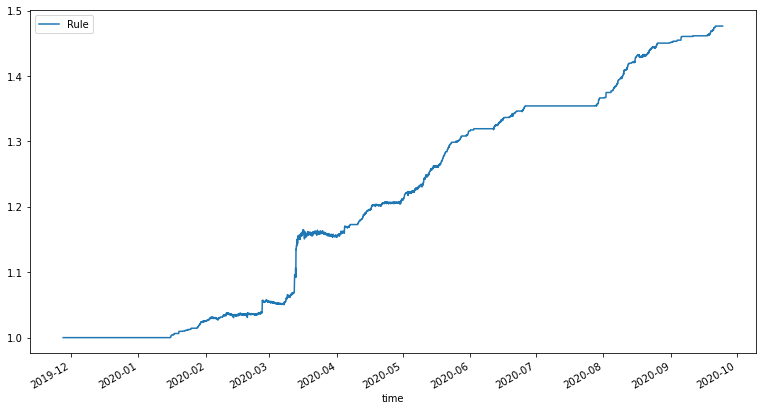

In [355]:
df_value_L3 = evm.get_df_val(df_rets[dataset['epi_no'] >= 9])
df_value_L3.plot()

### MDD

In [356]:
df_dd = evm.get_dd(df_value_L3)

<AxesSubplot:xlabel='time'>

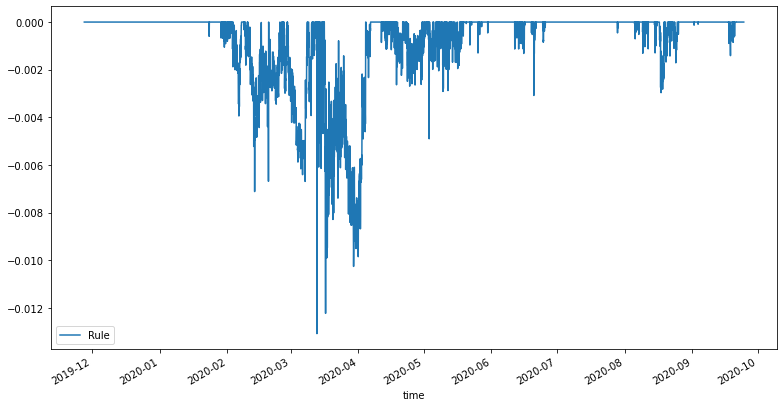

In [357]:
df_dd.plot()

### Turn Over

In [358]:
temp = dataset[dataset['epi_no'] >= 9].copy()
TO_Rule = len(temp[(temp['pre_pos_Rule'].shift() != temp['pre_pos_Rule'])])

In [359]:
print(f"Test기간 {len(temp)}틱 중")
print(f"Rule: {TO_Rule}회")
print("포지션 변경발생")

Test기간 6532틱 중
Rule: 687회
포지션 변경발생
